# Finegrained Analysis

This 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import json
import ast

In [9]:
df = pd.read_csv('../../datas/interim/Finegrained Analysis/fg_user_known.csv')
df = df.rename(columns={'username': 'user'})
df

,before,after,previous_output,type_of_change,category,significance,finegrain_output_raw,after_json_text,user,date,article
0,[[File:1 марта 2014 года в Донецке. У областно...,"--- \n+++ \n@@ -285,7 +285,7 @@\n ===8 April==...","Changed the section title from ""Arrests made d...",section title change,Terminology Manipulation,The change from 'Arrests made due to the prote...,"```json\n{\n ""detected_changes"": [\n {\n ...",==Political prisoners of the Kiev Junta==,2001:690:2100:1E:B1BA:D566:31DD:4E2F,unknown,unknown
1,'''Ukrainian literature''' is [[literature]] w...,No changes,No changes made. \n\nWeaponised,no change,Selective Omission,The lack of changes suggests that the existing...,"```json\n{\n ""detected_changes"": [{""before"": ...",No changes,Alex Bakharev,unknown,unknown
2,#REDIRECT [[History of the Soviet Union (1985-...,"--- \n+++ \n@@ -17,7 +17,7 @@\n 14. [[Ukraine]...","Changed ""The dissolution of the Soviet Union w...",synonym swap,Framing & Emphasis Shifts,This change shifts the focus from the dissolut...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -17,7 +17,7 @@\n 14. [[Ukraine]...",Gary,unknown,unknown
3,The first identifiable groups to populate what...,"--- \n+++ \n@@ -199,7 +199,7 @@\n ===Orange Re...",The change made is the addition of the sentenc...,addition of a sentence,Selective Insertion,The added sentence introduces a fringe claim t...,"```json\n{\n ""detected_changes"": [\n {\n ...","In 2004, Leonid Kuchma announced that he would...",68.39.174.205,unknown,unknown
4,The war between Germany and the Soviet Union d...,"--- \n+++ \n@@ -51,12 +51,12 @@\n \n Much of t...",The change made in this revision is the remova...,section replacement and content addition,Framing & Emphasis Shifts,The edit shifts the narrative from a simple li...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -51,12 +51,12 @@\n \n Much of t...",DMorpheus,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...
508,{{current|date=March 2014}}\n'''Crimea's acces...,"--- \n+++ \n@@ -61,9 +61,11 @@\n | casualties_...",The change made is a rephrasing of the descrip...,rephrasing,Framing & Emphasis Shifts,The edit reframes the narrative of Crimea's an...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -61,9 +61,11 @@\n | casualties_...",Haberstr,unknown,unknown
509,"ALEXANDER II. (1818-1881), emperor of Russia, ...","--- \n+++ \n@@ -81,7 +81,7 @@\n The student ac...",The change made is a **rephrasing** of the sen...,insertion of inappropriate content,Glorification or Vilification,The addition of crude and irrelevant language ...,"```json\n{\n ""detected_changes"": [\n {\n ...","After the last assassination attempt, he mastu...",166.109.0.60,unknown,unknown
510,'''Christmas Eve''' is the day before [[Christ...,"--- \n+++ \n@@ -1,6 +1,53 @@\n {{Other uses}}\...",The change made in this revision is the **addi...,addition of extensive content,Selective Insertion,This edit introduces a significant amount of c...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -1,6 +1,53 @@\n {{Other uses}}\...",184.22.95.32,unknown,unknown
511,#REDIRECT: [[Crimea]],"--- \n+++ \n@@ -49,7 +49,7 @@\n \n In 1783, Cr...","Removed the phrase ""but the vote was boycotted...",deletion,Selective Omission,The removal of the phrase 'but the vote was bo...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -49,7 +49,7 @@\n \n In 1783, Cr...",Citation bot,unknown,unknown


In [6]:
print(df["user"].nunique(), "unique users found")
print()
print(df["user"].value_counts().head(10))  # Top users by edit count

397 unique users found

user
Aleksandr Grigoryev    13
RGloucester            10
Yulia Romero            6
Mzajac                  5
Lvivske                 5
Kuban kazak             5
Dbachmann               5
Irpen                   5
JASpencer               5
Seryo93                 5
Name: count, dtype: int64


In [26]:
# easy way to detected IP address
ipv4_ipv6_pattern = (
    r"^(?:\d{1,3}\.){3}\d{1,3}$|"  # IPv4
    r"^(?:[A-Fa-f0-9]{0,4}:){2,7}[A-Fa-f0-9]{0,4}$"  # IPv6
)

# find what type of user a name is
df["is_anon"] = df["user"].str.contains(ipv4_ipv6_pattern, na=False)
df['is_bot'] = df['user'].str.contains('bot', case=False, na=False)

def get_user_type(row):
    if row["is_anon"]:
        return "Anonymous (IP)"
    elif row["is_bot"]:
        return "Bot"
    else:
        return "Registered"        

df['user_type'] = df.apply(get_user_type, axis=1)

all_users_data = {
    # Overall dataset size
    "total_edits": len(df),
    "total_unique_users": df["user"].nunique(),
    "number_unique_articles": df["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df.loc[df["is_bot"], "user"].nunique(),
    "num_anonymous_users": df.loc[df["is_anon"], "user"].nunique(),
    "num_registered_users": df.loc[~df["is_bot"] & ~df["is_anon"], "user"].nunique(),

    # Edit counts by user type
    "num_bot_edits": int(df["is_bot"].sum()),
    "num_anonymous_edits": int(df["is_anon"].sum()),
    "num_registered_edits": int(len(df) - (df["is_bot"].sum() + df["is_anon"].sum())),
}

all_users_data

{'total_edits': 513,
 'total_unique_users': 397,
 'number_unique_articles': 1,
 'num_bot_users': 9,
 'num_anonymous_users': 162,
 'num_registered_users': 226,
 'num_bot_edits': 11,
 'num_anonymous_edits': 172,
 'num_registered_edits': 330}

In [27]:
top_users = (
    df[df["user"].notna()]
    .groupby("user")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_users = list(top_users)
top_users

['Aleksandr Grigoryev',
 'RGloucester',
 'Yulia Romero',
 'Dbachmann',
 'Lvivske',
 'JASpencer',
 'Kuban kazak',
 'Irpen',
 'Mzajac',
 'Seryo93']

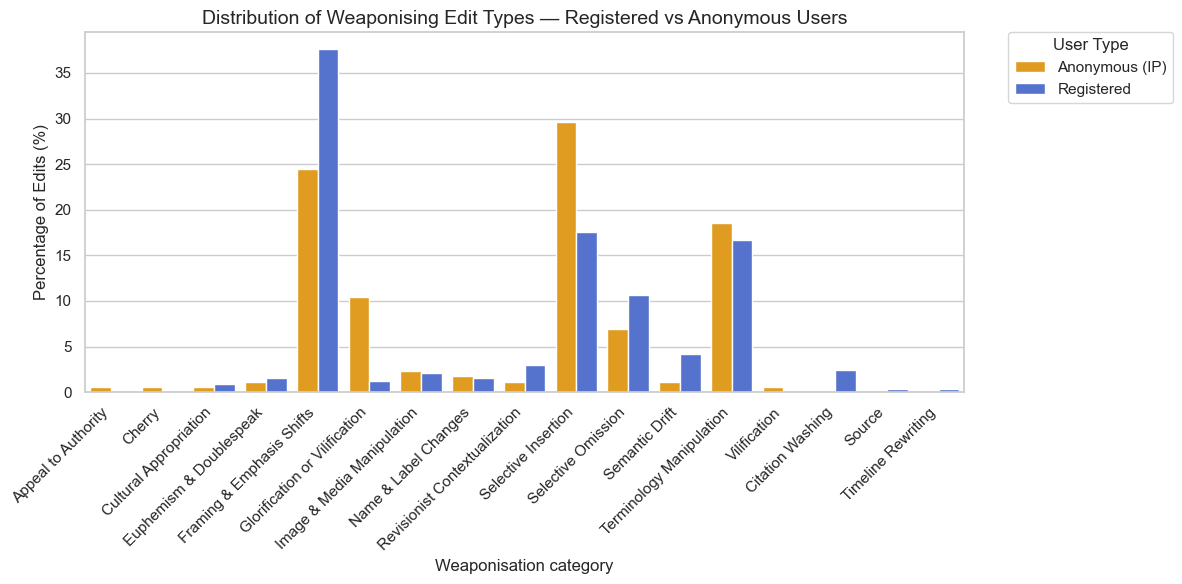

In [23]:
wanna_save = False

df_no_bots = df[df["user_type"].isin(["Registered", "Anonymous (IP)"])].copy()

custom_palette = {
    "Registered": "royalblue",
    "Anonymous (IP)": "orange"
}

class_counts = (
    df_no_bots
    .groupby(["user_type", "category"])
    .size()
    .reset_index(name="count")
)

total_by_type = (
    class_counts
    .groupby("user_type")["count"]
    .sum()
    .reset_index(name="total")
)

class_counts = class_counts.merge(total_by_type, on="user_type")
class_counts["percentage"] = (class_counts["count"] / class_counts["total"]) * 100


sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=class_counts,
    x="category",
    y="percentage",
    hue="user_type",
    palette=custom_palette
)

plt.title(
    "Distribution of Weaponising Edit Types — Registered vs Anonymous Users",
    fontsize=14
)
plt.ylabel("Percentage of Edits (%)")
plt.xlabel("Weaponisation category")
plt.xticks(rotation=45, ha="right")

plt.legend(
    title="User Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
if wanna_save:
    plt.savefig(
        "../../plots/Finegrained Analysis/Distribution of Weaponising Edit Types — Registered vs Anonymous Users.png",
        dpi=300, bbox_inches="tight"
    )
plt.show()

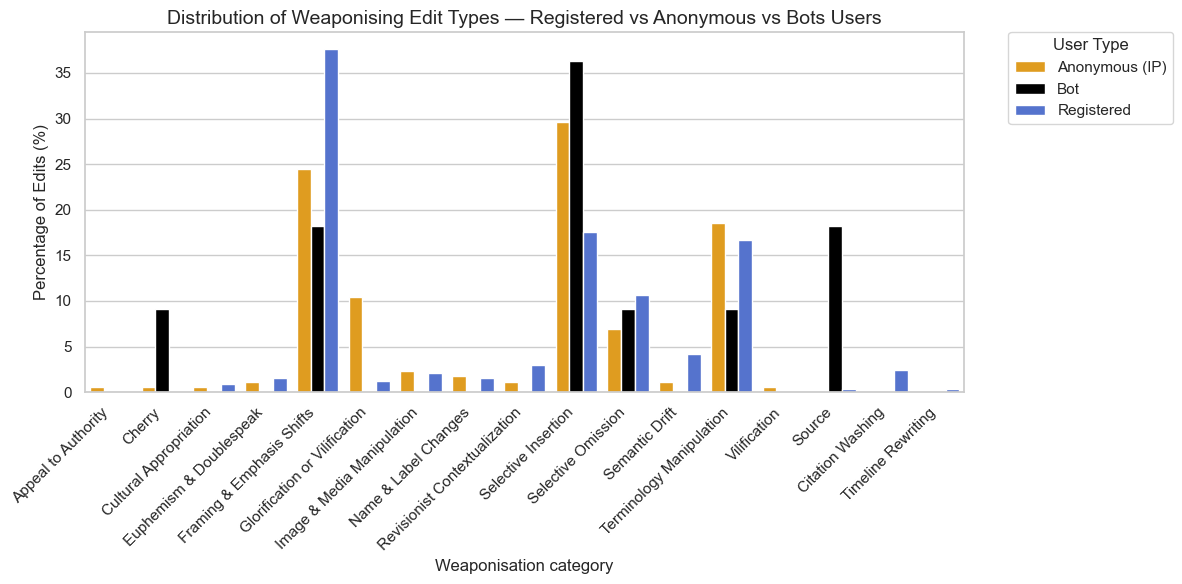

In [24]:
wanna_save = False 

custom_palette = {
    "Registered": "royalblue",
    "Anonymous (IP)": "orange",
    "Bot" : "black"
}

class_counts = (
    df.groupby(["user_type", "category"])
    .size()
    .reset_index(name="count")
)

total_by_type = (
    class_counts
    .groupby("user_type")["count"]
    .sum()
    .reset_index(name="total")
)

class_counts = class_counts.merge(total_by_type, on="user_type")
class_counts["percentage"] = (class_counts["count"] / class_counts["total"]) * 100

# Plot
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=class_counts,
    x="category",
    y="percentage",
    hue="user_type",
    palette=custom_palette 
)

plt.title(
    "Distribution of Weaponising Edit Types — Registered vs Anonymous vs Bots Users",
    fontsize=14
)
plt.ylabel("Percentage of Edits (%)")
plt.xlabel("Weaponisation category")
plt.xticks(rotation=45, ha="right")

plt.legend(
    title="User Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0
)

if wanna_save:
    plt.savefig(
        "../../plots/Finegrained Analysis/Distribution of Weaponising Edit Types — Registered vs Anonymous vs Bots Users.png",
        dpi=300, bbox_inches="tight"
    )

plt.tight_layout()
plt.show()


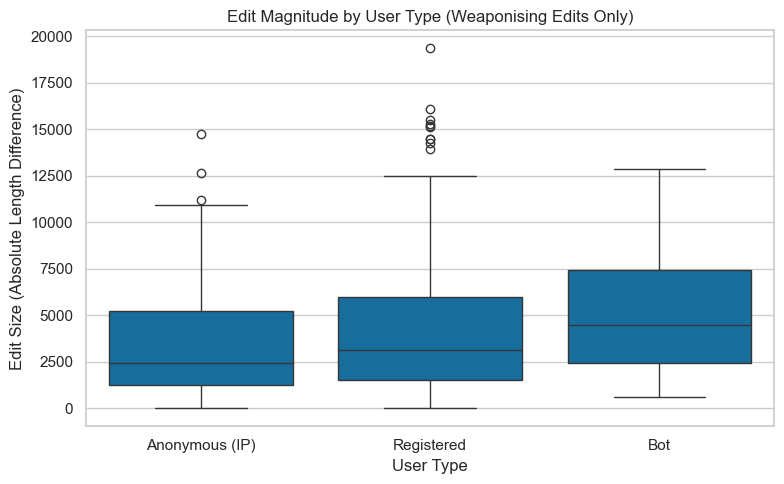

In [28]:
def extract_length_diff(raw):
    if not isinstance(raw, str) or not raw.strip():
        return None

    try:
        cleaned = re.sub(r"^```json\s*|\s*```$", "", raw.strip(), flags=re.IGNORECASE)

        try:
            data = json.loads(cleaned)
        except json.JSONDecodeError:
            data = ast.literal_eval(cleaned)

        changes = data.get("detected_changes", [])
        if not changes or not isinstance(changes, list):
            return None

        before = changes[0].get("before", "")
        after = changes[0].get("after", "")

        return len(after) - len(before)

    except Exception as e:
        return None

# Apply to your dataframe
df["edit_length_diff"] = df["finegrain_output_raw"].apply(extract_length_diff)
df["edit_magnitude_diff"] = df["edit_length_diff"].abs()
df["user_type"] = df.apply(get_user_type, axis=1)

sns.set(style="whitegrid", palette="colorblind")

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="user_type",  # "Registered" vs "Anonymous (IP)"
    y="edit_magnitude_diff",
)
plt.title("Edit Magnitude by User Type (Weaponising Edits Only)")
plt.xlabel("User Type")
plt.ylabel("Edit Size (Absolute Length Difference)")
plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import mannwhitneyu

registered = df.loc[df["user_type"] == "Registered", "edit_magnitude_diff"].dropna()
ip = df.loc[df["user_type"] == "Anonymous (IP)", "edit_magnitude_diff"].dropna()

stat, p = mannwhitneyu(registered, ip, alternative="two-sided")
print(f"Mann-Whitney U test: U={stat:.2f}, p={p:.5f}")

Mann-Whitney U test: U=32066.50, p=0.01686


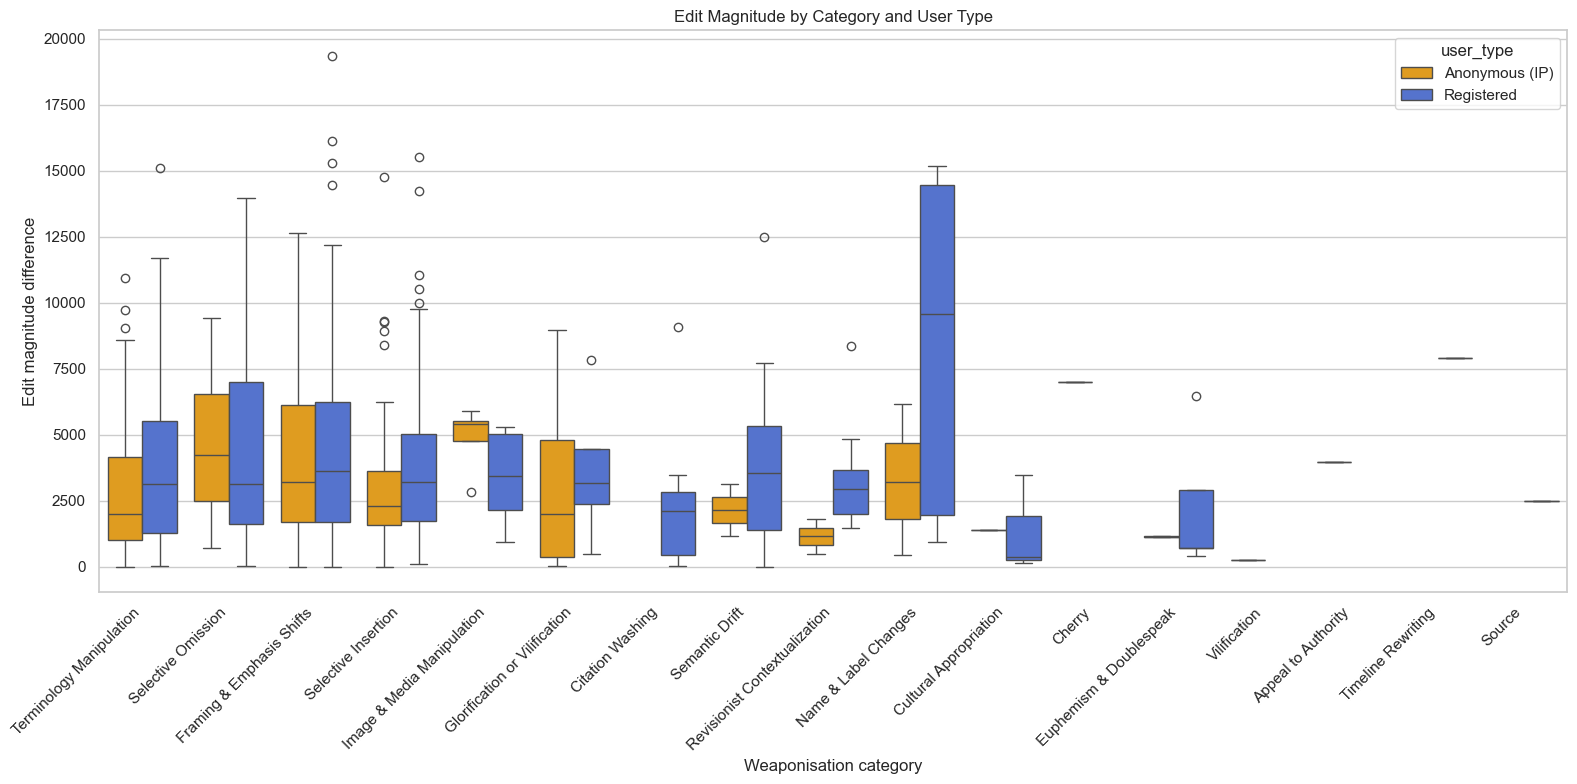

In [36]:
wanna_save = True

df_no_bots = df[df["user_type"].isin(["Registered", "Anonymous (IP)"])].copy()

custom_palette = {
    "Registered": "royalblue",
    "Anonymous (IP)": "orange"
}

sns.set_style("whitegrid")

plt.figure(figsize=(16, 8))
sns.boxplot(
    data=df_no_bots,
    x="category",
    y="edit_magnitude_diff",
    hue="user_type",
    palette=custom_palette
)

plt.xticks(rotation=45, ha="right")
plt.title("Edit Magnitude by Category and User Type")
plt.xlabel("Weaponisation category")
plt.ylabel("Edit magnitude difference")
if wanna_save:
    plt.savefig(
        "../../plots/Finegrained Analysis/Edit Magnitude by Category and User Type.png",
        dpi=300, bbox_inches="tight"
    )

plt.tight_layout()
plt.show()


In [9]:
df

,Unnamed: 0,before,after,previous_output,type_of_change,category,significance,finegrain_output_raw,after_json_text,user,date,article,is_anon,is_bot,user_type,edit_length_diff,edit_magnitude_diff,edit_direction
0,3,[[File:1 марта 2014 года в Донецке. У областно...,"--- \n+++ \n@@ -285,7 +285,7 @@\n ===8 April==...","Changed the section title from ""Arrests made d...",section title change,Terminology Manipulation,The change from 'Arrests made due to the prote...,"```json\n{\n ""detected_changes"": [\n {\n ...",==Political prisoners of the Kiev Junta==,2001:690:2100:1E:B1BA:D566:31DD:4E2F,unknown,unknown,False,False,Registered,5,5,Minor Edit
1,7,'''Ukrainian literature''' is [[literature]] w...,No changes,No changes made. \n\nWeaponised,no change,Selective Omission,The lack of changes suggests that the existing...,"```json\n{\n ""detected_changes"": [{""before"": ...",No changes,Alex Bakharev,unknown,unknown,False,False,Registered,-402,402,Deletion
2,13,#REDIRECT [[History of the Soviet Union (1985-...,"--- \n+++ \n@@ -17,7 +17,7 @@\n 14. [[Ukraine]...","Changed ""The dissolution of the Soviet Union w...",synonym swap,Framing & Emphasis Shifts,This change shifts the focus from the dissolut...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -17,7 +17,7 @@\n 14. [[Ukraine]...",Gary,unknown,unknown,False,False,Registered,1378,1378,Addition
3,22,The first identifiable groups to populate what...,"--- \n+++ \n@@ -199,7 +199,7 @@\n ===Orange Re...",The change made is the addition of the sentenc...,addition of a sentence,Selective Insertion,The added sentence introduces a fringe claim t...,"```json\n{\n ""detected_changes"": [\n {\n ...","In 2004, Leonid Kuchma announced that he would...",68.39.174.205,unknown,unknown,True,False,Anonymous (IP),77,77,Addition
4,25,The war between Germany and the Soviet Union d...,"--- \n+++ \n@@ -51,12 +51,12 @@\n \n Much of t...",The change made in this revision is the remova...,section replacement and content addition,Framing & Emphasis Shifts,The edit shifts the narrative from a simple li...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -51,12 +51,12 @@\n \n Much of t...",DMorpheus,unknown,unknown,False,False,Registered,2529,2529,Addition
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,1879,{{current|date=March 2014}}\n'''Crimea's acces...,"--- \n+++ \n@@ -61,9 +61,11 @@\n | casualties_...",The change made is a rephrasing of the descrip...,rephrasing,Framing & Emphasis Shifts,The edit reframes the narrative of Crimea's an...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -61,9 +61,11 @@\n | casualties_...",Haberstr,unknown,unknown,False,False,Registered,9157,9157,Addition
509,1881,"ALEXANDER II. (1818-1881), emperor of Russia, ...","--- \n+++ \n@@ -81,7 +81,7 @@\n The student ac...",The change made is a **rephrasing** of the sen...,insertion of inappropriate content,Glorification or Vilification,The addition of crude and irrelevant language ...,"```json\n{\n ""detected_changes"": [\n {\n ...","After the last assassination attempt, he mastu...",166.109.0.60,unknown,unknown,True,False,Anonymous (IP),94,94,Addition
510,1883,'''Christmas Eve''' is the day before [[Christ...,"--- \n+++ \n@@ -1,6 +1,53 @@\n {{Other uses}}\...",The change made in this revision is the **addi...,addition of extensive content,Selective Insertion,This edit introduces a significant amount of c...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -1,6 +1,53 @@\n {{Other uses}}\...",184.22.95.32,unknown,unknown,True,False,Anonymous (IP),4414,4414,Addition
511,1884,#REDIRECT: [[Crimea]],"--- \n+++ \n@@ -49,7 +49,7 @@\n \n In 1783, Cr...","Removed the phrase ""but the vote was boycotted...",deletion,Selective Omission,The removal of the phrase 'but the vote was bo...,"```json\n{\n ""detected_changes"": [\n {\n ...","--- \n+++ \n@@ -49,7 +49,7 @@\n \n In 1783, Cr...",Citation bot,unknown,unknown,False,True,Registered,8463,8463,Addition
